# Standardlastprofil

Dieses Jupyter Notebook soll eine kurzen Einblick in das Arbeiten mit Pandas und dem Standardlastprofil für das H0 Profil (Haushalt) demonstrieren.

Zuerst werden die benötigten Python Pakete importiert und konfiguriert.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = (12, 6)
ger_holidays = holidays.Germany()

### Lastprofil

Anschließend wird die CSV Datei mit den Werten für das H0 Profil geladen.

In [3]:
profil = pd.read_csv('../profile.csv', header=[0,1], index_col=0)
profil.head()

winter                  summer                transition               
     saturday sunday weekday saturday sunday weekday   saturday sunday weekday
0:15     70.8   87.5    67.6     89.8  100.1    86.3       80.2   93.4    77.8
0:30     68.2   81.1    60.8     84.9   92.5    76.9       75.1   86.8    69.6
0:45     65.9   75.0    54.9     80.7   85.9    68.8       70.7   81.2    62.4
1:00     63.3   69.1    49.9     76.6   79.9    62.4       66.6   75.7    56.6
1:15     59.5   63.4    46.2     71.7   74.1    58.0       62.3   70.1    52.5

Eine bessere Darstellung des oben gezeigten Verlaufs zeigt der folgende Plot. Hier werden die Verläufe für einen Samstag, einen Sonntag und für einen Wochentag im Winter gegenübergestellt.

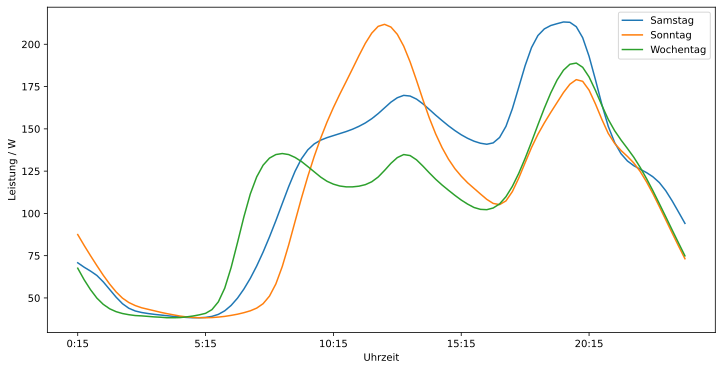

In [4]:
fig, ax = plt.subplots()
profil['winter', 'saturday'].plot(ax=ax, label='Samstag')
profil['winter', 'sunday'].plot(ax=ax, label='Sonntag')
profil['winter', 'weekday'].plot(ax=ax, label='Wochentag')
plt.xlabel("Uhrzeit")
plt.ylabel("Arbeit / Wh")
plt.legend()
plt.show()

Ferner können auch die einzelnen Jahreszeiten miteinander verglichen werden, z.B. für einen Werktag:

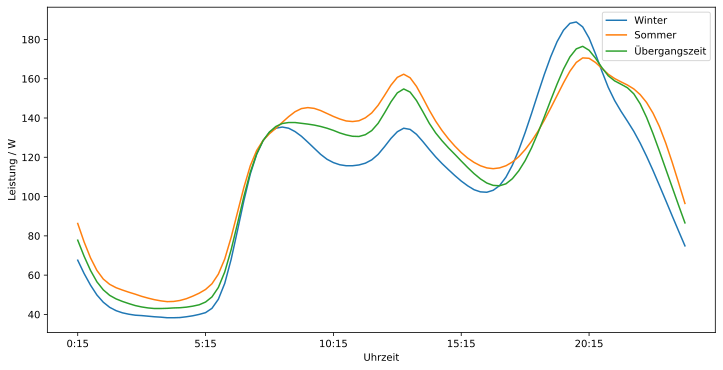

In [5]:
fig, ax = plt.subplots()
profil['winter', 'weekday'].plot(ax=ax, label='Winter')
profil['summer', 'weekday'].plot(ax=ax, label='Sommer')
profil['transition', 'weekday'].plot(ax=ax, label='Übergangszeit')
plt.xlabel("Uhrzeit")
plt.ylabel("Arbeit / Wh")
plt.legend()
plt.show()

### Dynamisierung
Da bei den Haushalten ein höhere Fluktuation der Werte im Vergleich zum Gewerbe oder zur Landwirtschaft auftritt, wird ein sogennanter Dynamisierungsfaktor verwendet. Multiplziert man einen aus dem H0 Profil entnommenen Wert mit dem dazugehörigen Dynmisierungswertes, so kann diese Fluktuation berücksichtigt werden. Diese Dyanamisierungswerte sind bereits im Vorfeld berechnet und zu Verfügung gestellt worden.

In [6]:
dynamics = pd.read_csv('../dynamisierung.csv')
dynamics = dynamics.set_index('day_no')
dynamics.head()

,date,value
day_no,,
1,1.01,1.2420
2,2.01,1.2439
3,3.01,1.2457
4,4.01,1.2473
5,5.01,1.2488


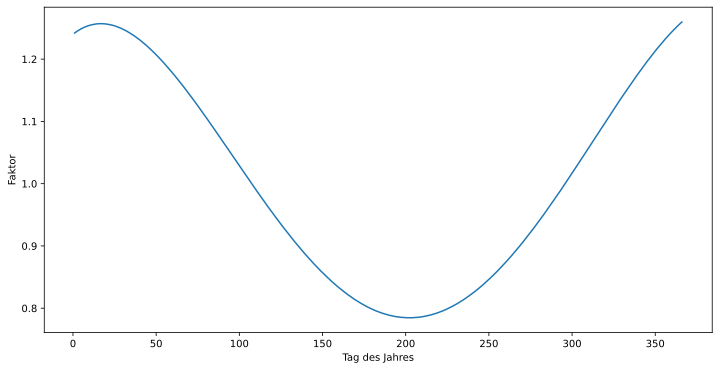

In [7]:
fig, ax = plt.subplots()
dynamics['value'].plot()
plt.xlabel("Tag des Jahres")
plt.ylabel("Faktor")
plt.show()

Das Plotten des Dynmisierungsfaktors lässt erkennen, dass dieser ein Cosinus-förmigen Verlauf besitzt. Dadurch kann z.B. der geringer Energiebedarf im Sommer miteinkalkuliert werden.

## Anwendung
Um die Anwendung des Standardlastprofils zu demonstrieren, wird der Verlauf vom 01.06.1996 bis zum 31.05.1997 erstellt. Dieser Zeitraum ist gewählt worden, da die offiziellen Dokumente ebenfalls diesen verwenden, wodurch die Richtigkeit der Anwendung überprüft werden kann. Das Berechnungsverfahren wird zunächst an einem Datum durchgeführt.

### Statischer Jahresverlauf
Zunächst werden zwei Funktionen definiert, welche bei späteren Berechnungen Verwendung sehen.

In [8]:
def day_type(d):
    if d in ger_holidays or d.isoweekday() == 7:
        return "sunday"
    # Handle christmas eve
    elif d.month == 12 and d.day == 24 and d.weekday() != 6:
        return "saturday"
    # Handle new years eve
    elif d.month == 12 and d.day == 31 and d.weekday() != 6:
        return "saturday"
    elif d.isoweekday() == 6:
        return "saturday"
    else:
        return "weekday"


def season_type(d):
    if d < datetime.datetime(d.year, 3, 21):
        return "winter"
    elif d < datetime.datetime(d.year, 5, 15):
        return "transition"
    elif d < datetime.datetime(d.year, 9, 15):
        return "summer"
    elif d < datetime.datetime(d.year, 11, 1):
        return "transition"
    else:
        return "winter"

Um die Ermittlung der statischen Werte zu vereinfachen wird `profil` transponiert verwendet. Dies sieht wie folgend aus.

In [9]:
profil.transpose()

0:15  0:30  0:45  1:00  1:15  1:30  1:45  2:00  2:15  \
winter     saturday   70.8  68.2  65.9  63.3  59.5  55.0  50.5  46.6  43.9   
           sunday     87.5  81.1  75.0  69.1  63.4  58.2  53.6  49.9  47.3   
           weekday    67.6  60.8  54.9  49.9  46.2  43.6  41.9  40.8  40.1   
summer     saturday   89.8  84.9  80.7  76.6  71.7  66.6  61.6  57.4  54.5   
           sunday    100.1  92.5  85.9  79.9  74.1  68.7  63.9  59.9  57.0   
           weekday    86.3  76.9  68.8  62.4  58.0  55.3  53.6  52.4  51.3   
transition saturday   80.2  75.1  70.7  66.6  62.3  58.0  54.1  50.8  48.4   
           sunday     93.4  86.8  81.2  75.7  70.1  64.5  59.3  54.9  51.7   
           weekday    77.8  69.6  62.4  56.6  52.5  49.7  47.9  46.6  45.5   

                     2:30  ...  21:45  22:00  22:15  22:30  22:45  23:00  \
winter     saturday  42.3  ...  131.0  128.2  126.1  124.1  121.6  118.2   
           sunday    45.5  ...  133.7  129.8  124.8  118.6  111.6  104.0   
           weekday   39.6  ...  138.4  133.2  127.2  120.5  113.3  105.7   
summer     saturday  52.6  ...  151.1  149.0  148.9  149.6  149.4  146.5   
           sunday    55.0  ...  149.3  147.3  145.4  143.0  139.2  133.2   
           weekday   50.3  ...  156.8  154.8  151.9  147.9  142.5  135.7   
transition saturday  46.8  ...  142.9  139.0  138.3  139.2  139.5  137.3   
           sunday    49.4  ...  143.6  141.5  137.5  131.8  124.7  116.5   
           weekday   44.5  ...  155.4  152.3  147.2  140.3  132.1  123.2   

                     23:15  23:30  23:45   0:00  
winter     saturday  113.4  107.4  100.8   94.1  
           sunday     96.2   88.4   80.7   73.2  
           weekday    98.0   90.2   82.5   74.9  
summer     saturday  139.8  130.3  119.5  109.0  
           sunday    124.4  113.8  102.5   91.6  
           weekday   127.2  117.5  107.1   96.5  
transition saturday  131.1  121.9  111.5  101.5  
           sunday    107.6   98.4   89.2   80.7  
           weekday   114.0  104.8   95.6   86.6  

[9 rows x 96 columns]

Jetzt können die Werte eines Datums ermittelt werden. Dazu dient die Funktion `static_profile_values`, welche an dem 4. Mai 1997 demonstriert wird.

Jahreszeit: transition, Wochentag: sunday


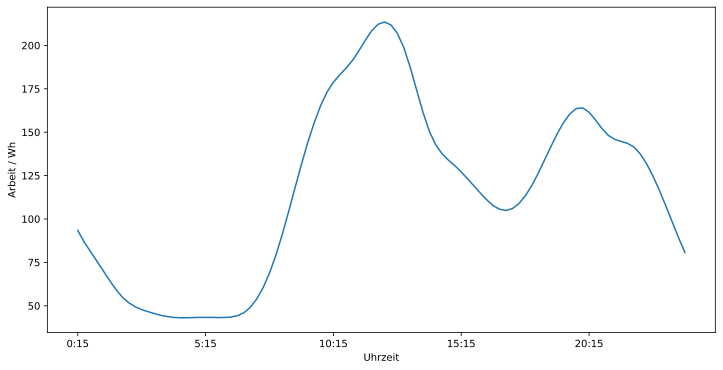

In [36]:
def static_profile_values(date):
    return profil.transpose().loc[season_type(date), day_type(date)]

requested_date = datetime.datetime.strptime('1997-05-04', '%Y-%m-%d')

print(f"Jahreszeit: {season_type(requested_date)}, Wochentag: {day_type(requested_date)}")
ax = plt.subplot()
static_profile_values(requested_date).plot(ax=ax);
plt.xlabel("Uhrzeit")
plt.ylabel("Arbeit / Wh")
plt.show()

Das ermittelte Profil entspricht genau den Erwartungen an ein SLP eines Sonntages.

Zur genauen Überprüfung der Werte werden alle Werte im Interval vom 01.06.1996 bis zum 31.05.1997 mit den Werten aus dem Beispielprofil verglichen. Das Beispiel sieht wie folgend aus.

In [16]:
static_sample = pd.read_csv('static_sample.csv')
static_sample.head()

,0:15,0:30,0:45,1:00,1:15,1:30,1:45,2:00,2:15,2:30,...,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,0:00
0,89.8,84.9,80.7,76.6,71.7,66.6,61.6,57.4,54.5,52.6,...,151.1,149.0,148.9,149.6,149.4,146.5,139.8,130.3,119.5,109.0
1,100.1,92.5,85.9,79.9,74.1,68.7,63.9,59.9,57.0,55.0,...,149.3,147.3,145.4,143.0,139.2,133.2,124.4,113.8,102.5,91.6
2,86.3,76.9,68.8,62.4,58.0,55.3,53.6,52.4,51.3,50.3,...,156.8,154.8,151.9,147.9,142.5,135.7,127.2,117.5,107.1,96.5
3,86.3,76.9,68.8,62.4,58.0,55.3,53.6,52.4,51.3,50.3,...,156.8,154.8,151.9,147.9,142.5,135.7,127.2,117.5,107.1,96.5
4,86.3,76.9,68.8,62.4,58.0,55.3,53.6,52.4,51.3,50.3,...,156.8,154.8,151.9,147.9,142.5,135.7,127.2,117.5,107.1,96.5


In [26]:
idx = pd.date_range("1996-06-01", "1997-05-31", freq='D')
data = []
for i in idx:
    data.append(static_profile_values(i))
df = pd.DataFrame(data).reset_index(drop=True)
df.head()

,0:15,0:30,0:45,1:00,1:15,1:30,1:45,2:00,2:15,2:30,...,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,0:00
0,89.8,84.9,80.7,76.6,71.7,66.6,61.6,57.4,54.5,52.6,...,151.1,149.0,148.9,149.6,149.4,146.5,139.8,130.3,119.5,109.0
1,100.1,92.5,85.9,79.9,74.1,68.7,63.9,59.9,57.0,55.0,...,149.3,147.3,145.4,143.0,139.2,133.2,124.4,113.8,102.5,91.6
2,86.3,76.9,68.8,62.4,58.0,55.3,53.6,52.4,51.3,50.3,...,156.8,154.8,151.9,147.9,142.5,135.7,127.2,117.5,107.1,96.5
3,86.3,76.9,68.8,62.4,58.0,55.3,53.6,52.4,51.3,50.3,...,156.8,154.8,151.9,147.9,142.5,135.7,127.2,117.5,107.1,96.5
4,86.3,76.9,68.8,62.4,58.0,55.3,53.6,52.4,51.3,50.3,...,156.8,154.8,151.9,147.9,142.5,135.7,127.2,117.5,107.1,96.5


In [27]:
pd.concat([df, static_sample]).drop_duplicates(keep=False)

,0:15,0:30,0:45,1:00,1:15,1:30,1:45,2:00,2:15,2:30,...,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,0:00


Die Entfernung aller Zeilen zeigt, dass der Inhalt der `df` DataFrames komplett mit dem des Beispiels übereinstimmt.

### Dynamisierung
Um aus den statischen Werten dynamische zu generieren, werden die Werte eines jeden Tages mit dem zu dem Tag dazugehörenden Wert multipliziert. Der zu dem ausgewählten Datum gehörende Werte ist 0,9384.

In [39]:
dynamics.loc[requested_date.timetuple().tm_yday]

date     3.0500
value    0.9384
Name: 124, dtype: float64

Wie bei den statischen Werten wird eine Funktion, `dynamic_profile_values`, benutzt, um die entprechenden Werte zu ermitteln.

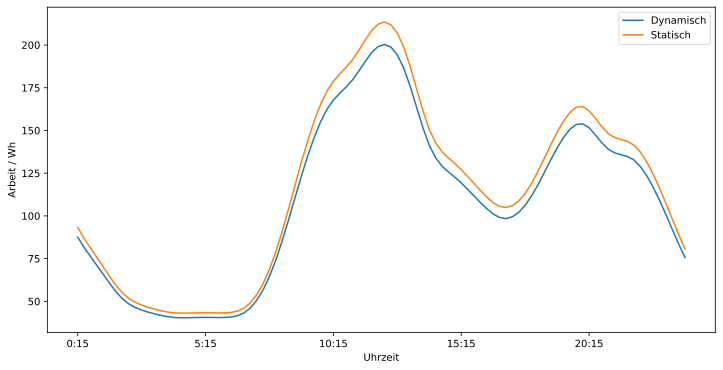

In [46]:
def dynamic_profile_values(date):
    return static_profile_values(date).mul(dynamics.loc[date.timetuple().tm_yday]['value']).round(1)

fig, ax = plt.subplots()
dynamic_profile_values(requested_date).plot(ax=ax, label='Dynamisch');
static_profile_values(requested_date).plot(ax=ax, label='Statisch');
plt.xlabel("Uhrzeit")
plt.ylabel("Arbeit / Wh")
plt.legend()
plt.show()

Die Gegenüberstellung zeigt, dass sich die dynamischen Werte aufgrund des Faktors 0,9384 etwas geringer sind als die statischen Werte.

Zuletzt müssen diese Werte noch mit den Vorgabewerten verglichen werden, um die Korrektheit der Berechnung zu bestätigen.

In [52]:
dynamic_sample = pd.read_csv('dynamic_sample.csv')
dynamic_sample.head()

,0:15,0:30,0:45,1:00,1:15,1:30,1:45,2:00,2:15,2:30,...,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,0:00
0,76.3,72.1,68.5,65.1,60.9,56.6,52.3,48.7,46.3,44.7,...,128.3,126.5,126.5,127.1,126.9,124.4,118.7,110.7,101.5,92.6
1,84.8,78.3,72.7,67.7,62.7,58.2,54.1,50.7,48.3,46.6,...,126.4,124.7,123.1,121.1,117.9,112.8,105.3,96.4,86.8,77.6
2,72.9,64.9,58.1,52.7,49.0,46.7,45.3,44.2,43.3,42.5,...,132.4,130.7,128.3,124.9,120.3,114.6,107.4,99.2,90.4,81.5
3,72.7,64.7,57.9,52.5,48.8,46.6,45.1,44.1,43.2,42.3,...,132.0,130.3,127.9,124.5,120.0,114.2,107.1,98.9,90.2,81.2
4,72.5,64.6,57.8,52.4,48.7,46.4,45.0,44.0,43.1,42.2,...,131.6,130.0,127.5,124.2,119.6,113.9,106.8,98.6,89.9,81.0


In [47]:
idx = pd.date_range("1996-06-01", "1997-05-31", freq='D')
data = []
for i in idx:
    data.append(dynamic_profile_values(i))
df = pd.DataFrame(data).reset_index(drop=True)
df.head()

,0:15,0:30,0:45,1:00,1:15,1:30,1:45,2:00,2:15,2:30,...,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,0:00
0,76.3,72.1,68.5,65.1,60.9,56.6,52.3,48.7,46.3,44.7,...,128.3,126.5,126.5,127.1,126.9,124.4,118.7,110.7,101.5,92.6
1,84.8,78.3,72.7,67.7,62.7,58.2,54.1,50.7,48.3,46.6,...,126.4,124.7,123.1,121.1,117.9,112.8,105.3,96.4,86.8,77.6
2,72.9,64.9,58.1,52.7,49.0,46.7,45.3,44.2,43.3,42.5,...,132.4,130.7,128.2,124.9,120.3,114.6,107.4,99.2,90.4,81.5
3,72.7,64.7,57.9,52.5,48.8,46.6,45.1,44.1,43.2,42.3,...,132.0,130.3,127.9,124.5,120.0,114.2,107.1,98.9,90.2,81.2
4,72.4,64.6,57.8,52.4,48.7,46.4,45.0,44.0,43.1,42.2,...,131.6,130.0,127.5,124.2,119.6,113.9,106.8,98.6,89.9,81.0


In [53]:
pd.concat([df, dynamic_sample]).drop_duplicates(keep=False)

,0:15,0:30,0:45,1:00,1:15,1:30,1:45,2:00,2:15,2:30,...,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45,0:00
0,76.3,72.1,68.5,65.1,60.9,56.6,52.3,48.7,46.3,44.7,...,128.3,126.5,126.5,127.1,126.9,124.4,118.7,110.7,101.5,92.6
1,84.8,78.3,72.7,67.7,62.7,58.2,54.1,50.7,48.3,46.6,...,126.4,124.7,123.1,121.1,117.9,112.8,105.3,96.4,86.8,77.6
2,72.9,64.9,58.1,52.7,49.0,46.7,45.3,44.2,43.3,42.5,...,132.4,130.7,128.2,124.9,120.3,114.6,107.4,99.2,90.4,81.5
4,72.4,64.6,57.8,52.4,48.7,46.4,45.0,44.0,43.1,42.2,...,131.6,130.0,127.5,124.2,119.6,113.9,106.8,98.6,89.9,81.0
5,72.3,64.4,57.6,52.2,48.6,46.3,44.9,43.9,42.9,42.1,...,131.3,129.6,127.2,123.8,119.3,113.6,106.5,98.4,89.7,80.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,87.2,80.6,74.8,69.6,64.5,59.8,55.6,52.2,49.6,47.9,...,130.0,128.3,126.6,124.5,121.2,116.0,108.3,99.1,89.3,79.8
361,74.4,66.3,59.3,53.8,50.0,47.7,46.2,45.2,44.2,43.4,...,135.2,133.5,131.0,127.6,122.9,117.0,109.7,101.3,92.4,83.2
362,86.1,79.5,73.9,68.7,63.7,59.1,54.9,51.5,49.0,47.3,...,128.4,126.6,125.0,122.9,119.7,114.5,106.9,97.8,88.1,78.8
363,74.0,65.9,59.0,53.5,49.7,47.4,45.9,44.9,44.0,43.1,...,134.4,132.7,130.2,126.8,122.1,116.3,109.0,100.7,91.8,82.7


Da die Berechnung von Fließkommazahlen mit Rundungsfehlern behaftet ist, muss eine andere Methode der Datenüberprüfung angewendet werden. Hierzu wird die Funktion `np.isclose` benutzt, da diese bei dem Vergleichen von Werten Toleranzen berücksichtigt [Doku](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html).

In [78]:
pass_count = 0
fail_count = 0
for i in range(df.index.size):
    cmp = np.isclose(df.loc[i], dynamic_sample.loc[i])
    pass_count += np.count_nonzero(cmp == True)
    fail_count += np.count_nonzero(cmp == False)

sum_count = pass_count + fail_count
print(f"Fails: {fail_count} [{fail_count / sum_count * 100:.3}%]")
print(f"Passes: {pass_count} [{pass_count / sum_count * 100:.3}%]")

Fails: 1315 [3.75%]
Passes: 33725 [96.2%]


Somit lieft die Genauigkeit dieser Berechnungsmethode bei 96,2%.